## Task 1

### This Colab notebook is based on Chapter 4 of the "Deep Learning with PyTorch Step-by-Step" book: https://github.com/dvgodoy/PyTorchStepByStep

In [1]:
!git clone https://github.com/aig-upf/DLSS-public.git
!mv /content/DLSS-public /content/DLSS

Cloning into 'DLSS-public'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 148 (delta 1), reused 15 (delta 1), pack-reused 133
Receiving objects: 100% (148/148), 109.50 MiB | 22.76 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
from IPython.core.display import display, HTML, Image
display(HTML(""))

import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from DLSS.day1.Utils.Data_generation.image_classification import *
from DLSS.day1.Utils.Model.v0 import *
from DLSS.day1.Utils.Utils_nb3 import *

from IPython.display import Image, display

# Classifying Images

In this notebook we will train a deep learning model for image classification

## Create and Visualize Dataset

Here we will generate some very simple images were we would have diagonal or not diagonal line classes.

### **[optional] Look in the file "day1/Utils/Data_generation/image_classification.py" to see how the dataset is generated.**


In [3]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

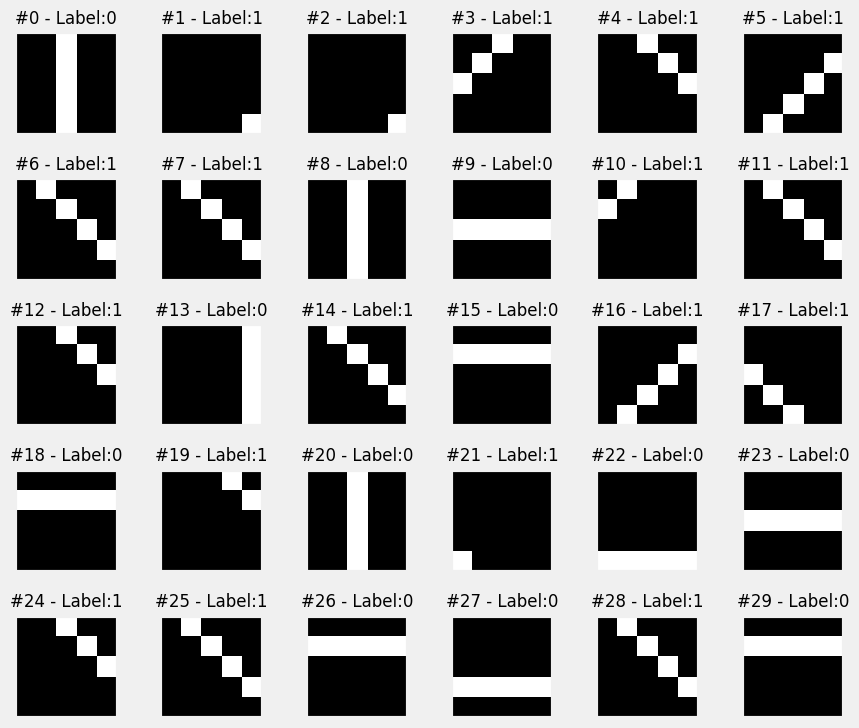

In [4]:
fig = plot_images(images, labels, n_plot=30)

### Transformation and Data Augmentation

####Random Horizontal Flip Transform

Original Image


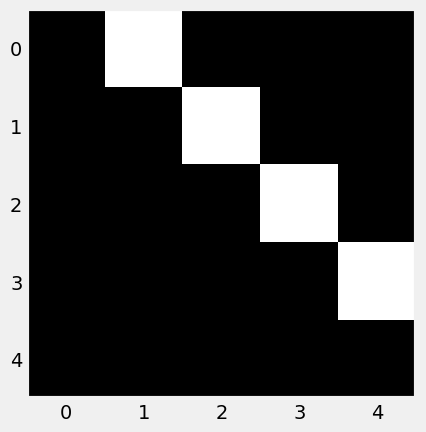

Flipped Image


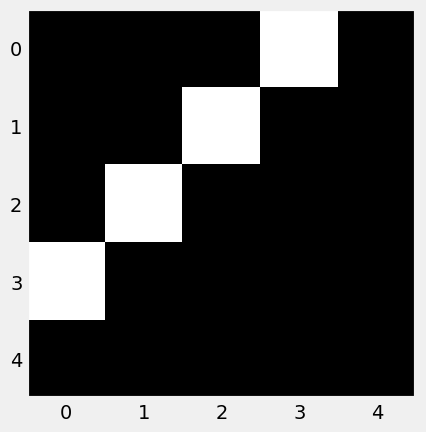

In [5]:
example = images[7]

example_hwc = np.transpose(example, (1, 2, 0))

tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_img = ToPILImage()(example_tensor)
print("Original Image")
plt.imshow(example_img, cmap='gray')
plt.grid(False)
plt.show()

flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)
print("Flipped Image")
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)
plt.show()

#### Normalize Transform

$$
\Large
\begin{aligned}
input = 0 \implies \frac{0 - mean}{std}= \frac{0 - 0.5}{0.5}&=-1
\\
input = 1 \implies \frac{1 - mean}{std}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

In [6]:
img_tensor = tensorizer(example)
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)

print("original image:\n\n", img_tensor)
print("\n\nnormalized image:\n\n", normalized_tensor)

original image:

 tensor([[[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0.]]])


normalized image:

 tensor([[[-1., -1., -1., -1., -1.]],

        [[ 1., -1., -1., -1., -1.]],

        [[-1.,  1., -1., -1., -1.]],

        [[-1., -1.,  1., -1., -1.]],

        [[-1., -1., -1.,  1., -1.]]])


### Create the Dataset applying the transformation we have seen

In [9]:
def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)
  # Makes the split argument a tensor
  splits_tensor = torch.as_tensor(splits)
  # Finds the correct multiplier, so we don't have
  # to worry about summing up to N (or one)
  multiplier = n / splits_tensor.sum()
  splits_tensor = (multiplier * splits_tensor).long()
  # If there is a difference, throws at the first split
  # so random_split does not complain
  diff = n - splits_tensor.sum()
  splits_tensor[0] += diff
  # Uses PyTorch random_split to split the indices
  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)


class TransformedTensorDataset(Dataset):
 def __init__(self, x, y, transform=None):
  self.x = x
  self.y = y
  self.transform = transform

 def __getitem__(self, index):
  x = self.x[index]

  if self.transform:
    x = self.transform(x)

  return x, self.y[index]

 def __len__(self):
  return len(self.x)


def make_balanced_sampler(y):
  # Computes weights for compensating imbalanced classes
  classes, counts = y.unique(return_counts=True)
  weights = 1.0 / counts.float()
  sample_weights = weights[y.squeeze().long()]
  # Builds sampler with compute weights
  generator = torch.Generator()
  sampler = WeightedRandomSampler(
  weights=sample_weights,
  num_samples=len(sample_weights),
  generator=generator,
  replacement=True
  )
  return sampler



# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
 Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Shallow Model with a single layer

Here we will create our logistic regression model, we have 25 features from $x_0$ to $x_{24}$

$$
\Large P(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

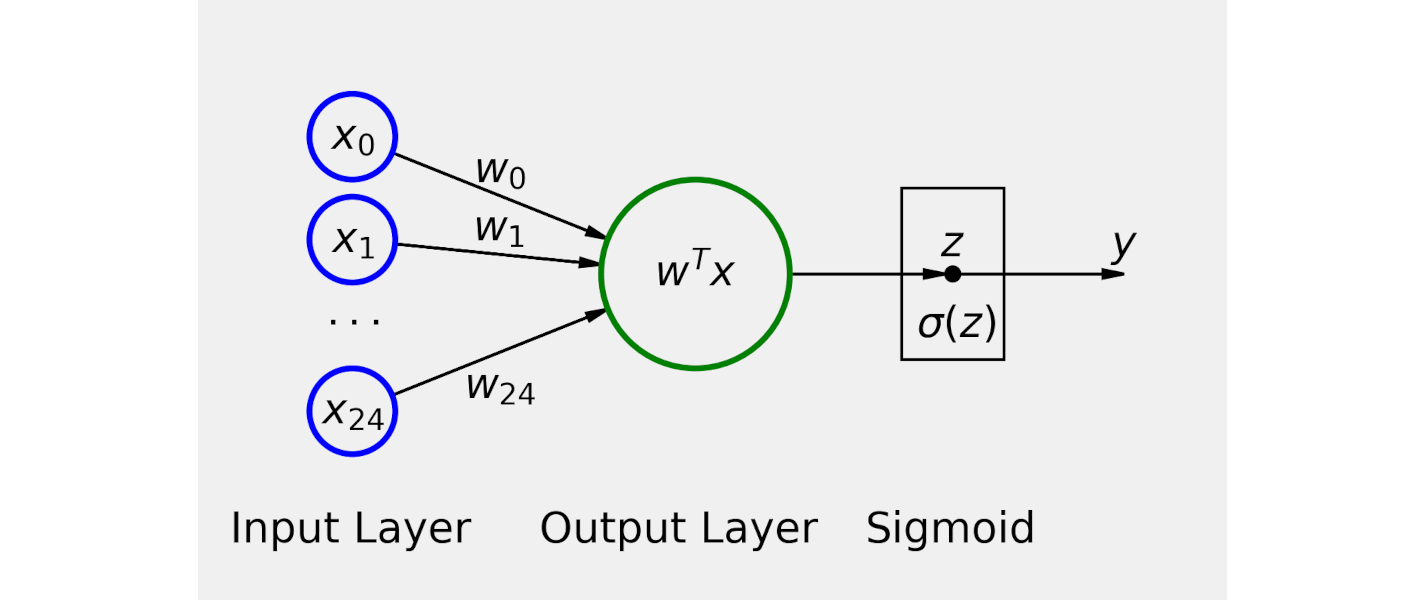

In [44]:
display(Image('/content/DLSS/day1/Images/classification.png'))

### Notation

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X =
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large
\begin{aligned}
z
& = W^T \cdot X
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\cdot
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\cdot
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration

### ***QUESTION: When training a neural network, we often have to construct the network from multiple components. Which are the components of the network in the case of the shallow model with a single layer? Which are the different functions for constructing these components, adding the dataset, and training the network?***


**Components of a Shallow Neural Network**

*   Input Layer: This is where the data enters the network. In a shallow network, this layer directly connects to the output layer without any hidden layers in between.
*   Output Layer: The layer that produces the final output of the network. For classification tasks, it often uses a softmax activation function for multi-class classification or a sigmoid function for binary classification.
The layer's design depends on the number of classes (e.g., one node for binary classification or multiple nodes for multi-class classification).
*   Weights and Biases: These are the learnable parameters of the network. In a single-layer network, these parameters connect the input layer to the output layer. They determine the strength of the influence that the input features have on the output.   
*  Activation Function: This is a function applied at the output layer. It introduces non-linearity to the model and helps in making decisions. Common choices are ReLU, sigmoid, and softmax.


**Functions for Constructing Network Components**

*   Defining the Network Structure: The network is constructed by defining its architecture, which includes the input and output layers, along with their associated weights and biases.
* Dataset Preparation: The data used to train the network needs to be prepared, which involves tasks like normalization, reshaping, and possibly augmentation to improve model robustness.
*   Loss Function: This function measures how well the network is performing. In classification tasks, common loss functions include cross-entropy loss for multi-class classification and binary cross-entropy loss for binary classification.
* Optimizer: This is an algorithm that adjusts the weights and biases to minimize the loss function. Common optimizers are Stochastic Gradient Descen and variations like Adam.


**Functions for Dataset and Training**

*   Training Process: Training involves feeding the input data through the network, calculating the loss, and using an optimizer to adjust the network's parameters. This process is typically iterated over several epochs, where an epoch represents one pass through the entire dataset.
* Training Loop: Involves iterating over the dataset, performing forward and backward passes, and updating the network's parameters.
* Evaluation and Tuning: After training, the network is evaluated using a separate validation or test dataset to assess its performance. Based on this evaluation, the network's architecture or training process may be adjusted for optimization.







### ***QUESTION: What is the purpose of the module "Flatten"?***


The purpose of the module "Flatten" is to convert multi-dimensional input to 1D since neural networks, particularly those without convolutional layers, often require input data in a flat, one-dimensional format. So the "Flatten" module takes multi-dimensional input data (like a 2D image) and "flattens" it into a single long vector. This way the image can be processed by the subsequent linear layer. The module ensures that the underlying information and structure of the data are maintained.

In [29]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [30]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

In [ ]:
fig = sbs_logistic.plot_losses()

## Shallow Model with linear activations

Now let's move from the simple logistic regression to a model with 3 layers and linear activations

In [ ]:
display(Image('/content/DLSS/day1/Images/classification_equiv.png'))

### Model Configuration

### ***QUESTION: How do you construct a network with multiple layers? Is the order of function calls important when constructing the network?***





**Constructing a multi-layer network**


*   Defining the Architecture: Decide the types and number of layers, and set parameters like the number of neurons, activation functions, weights and biases.
*   Layer Sequencing: Add layers in a specific sequence. This order is critical as it defines the flow of data and the overall structure of the network.
* Configuration: Choose an optimizer, a loss function, and performance metrics. This step configures how the network learns.
* Training: Fit the model to training data, adjusting weights through backpropagation based on the loss function.

In a shallow network with linear activations, the order in which the layers are defined and executed is crucial. The data flows from the input layer through the hidden layers and finally through the output layer. The output of one layer becomes the input to the next. Stacking multiple linear layers without any non-linear activation functions essentially collapses the model into a single linear transformation. This is because the composition of linear functions is still a linear function.





### ***QUESTION: What happens when you call the module "Linear" with "bias = False"?***

When you call the Linear module with the parameter bias=False, it creates a linear layer without a bias term. The bias term in a linear layer allows the layer to learn an offset. It provides additional flexibility, enabling the layer to shift the activation function to the left or right, which can be critical for modeling certain types of data. Without a bias, the linear transformation (i.e., the layer’s output) is strictly dependent on the input and the weight matrix. This simplifies the model but at the cost of reduced flexibility in the layer's ability to model data.







In [32]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [33]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

As you can see below here the Logistic model and the linear-layer Network have the same performance, we need to add non-linear activation to get better results!

In [ ]:
fig = sbs_nn.plot_losses()

In [ ]:
fig = figure5(sbs_logistic, sbs_nn)

### Show Me the Math!

$$
\large
\begin{array}{rcccccccccccc}
Hidden\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
\cdot
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
Hidden\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
\cdot
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
Output &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
\cdot
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
substituting\ z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{Output\ Layer}
&
\cdot
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{Hidden\ Layer\#1}
& &
\cdot
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{Hidden\ Layer\#0}
&
\cdot
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
multiplying... & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{Matrices\ Multiplied}
&
\cdot
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$

## Activation Functions

Activation function are nonlinear functions necessary to create our first deep learning model.



### Sigmoid

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

tensor([0.0474, 0.5000, 0.9526])

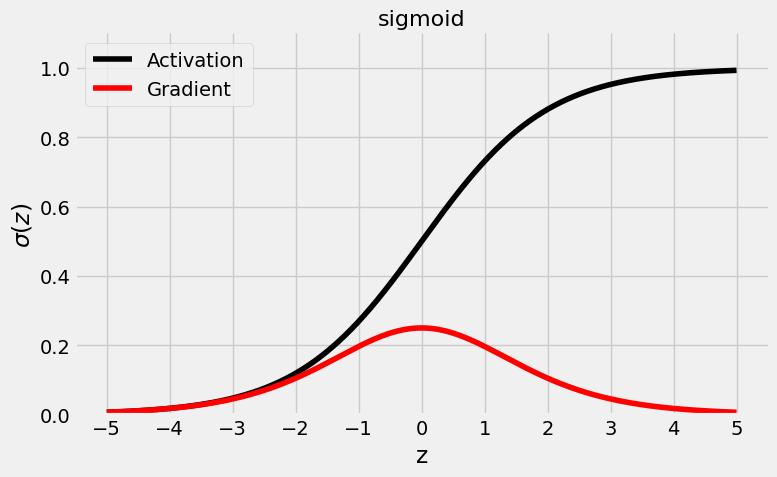

In [36]:
fig = plot_activation(torch.sigmoid)

dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

### Hyperbolic Tangent (Tanh)

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

tensor([-0.9951,  0.0000,  0.9951])

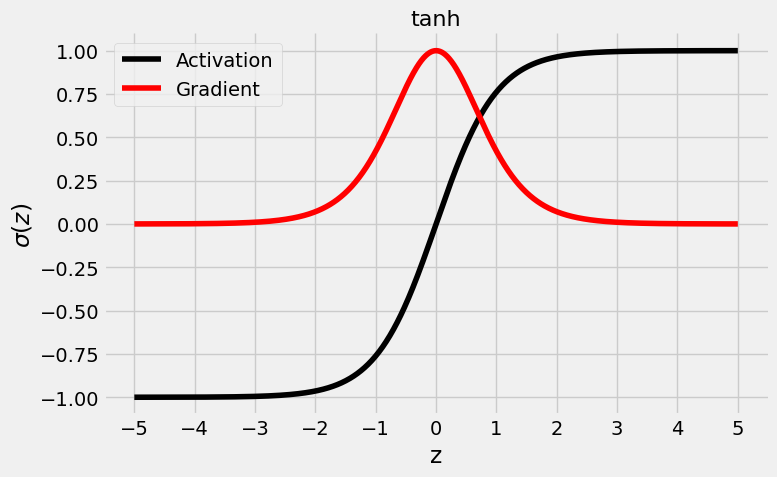

In [37]:
fig = plot_activation(torch.tanh)

dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

nn.Tanh()(dummy_z)

### Rectified Linear Unit (ReLU)

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ if\ \ z \ge 0
\\
0,\ if \ \ z < 0
\end{cases}
\\
& or
\\
\sigma(z) &= max(0, z)
\end{aligned}
$$

tensor([0., 0., 3.])

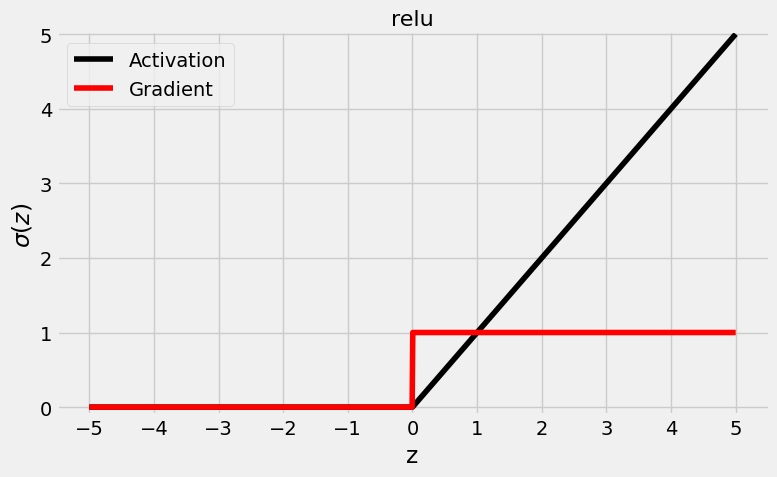

In [38]:
fig = plot_activation(torch.relu)

dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

nn.ReLU()(dummy_z)

dummy_z.clamp(min=0)

### Leaky ReLU

$$
\Large
\sigma(z) =
\begin{cases}
z,\ if\ \ z \ge 0
\\
0.01z,\ if \ \ z < 0
\end{cases}
\\
or
\\
\Large
\sigma(z)=max(0,z)+0.01min(0,z)
$$

tensor([-0.0600,  0.0000,  3.0000])

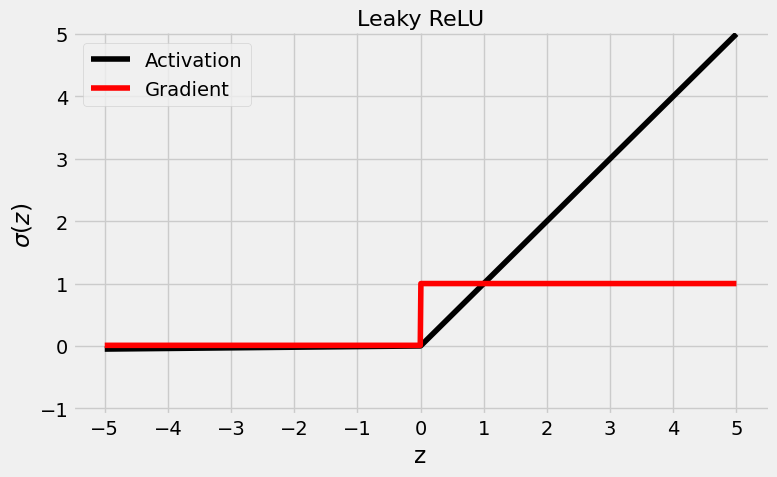

In [39]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

nn.LeakyReLU(negative_slope=0.02)(dummy_z)

### Parametric ReLU (PReLU)

$$
\Large
\sigma(z) =
\begin{cases}
z,\ if\ \ z \ge 0
\\
az,\ if \ \ z < 0
\end{cases}
\\
or
\\
\Large
\sigma(z)=max(0,z)+a\ min(0,z)
$$

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

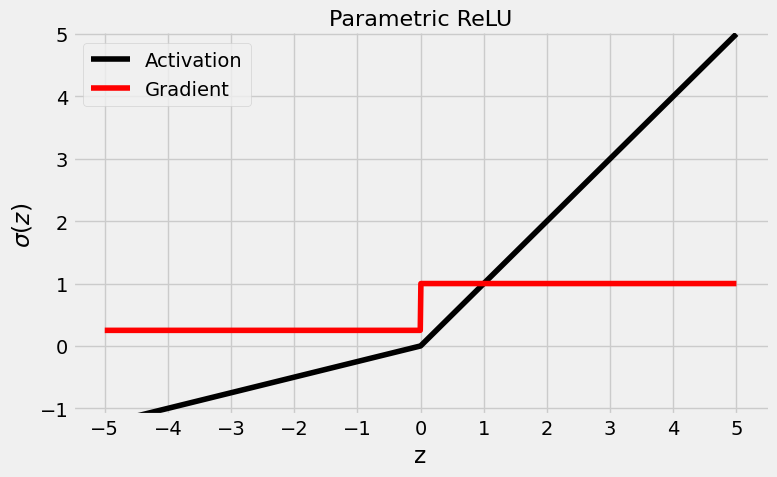

In [40]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

nn.PReLU(init=0.25)(dummy_z)

## Deep Neural Network Model

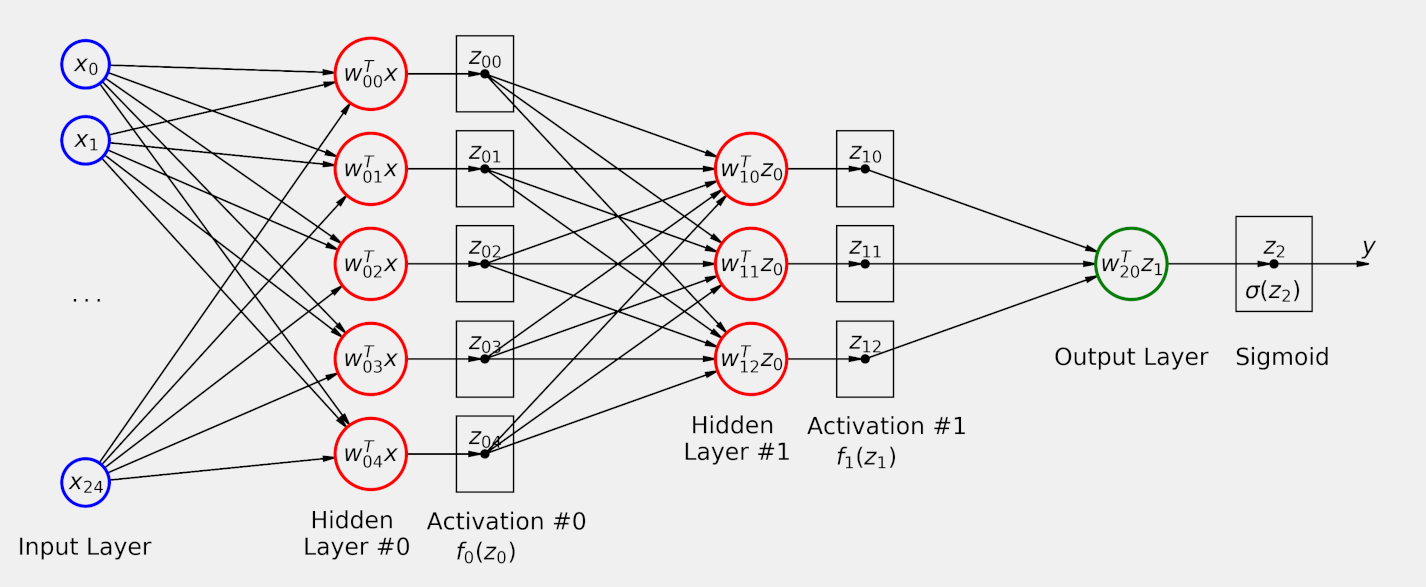

In [41]:
display(Image('/content/DLSS/day1/Images/classification_relu2.png'))

### Model Configuration

### ***QUESTION: How can we add non-linear activation function to the intermediate layers?***

Non-linear activation functions enable a neural network to capture complex patterns in the data, which is not possible with linear models alone. Modifing the network architecture means incorporating the chosen activation function into your neural network architecture. In a layered architecture, this typically involves adding an activation function after each linear layer. Therefore in the Sequential Model we add the activation function as a separate layer immediately following each linear layer. we have to ensure that the activation functions are correctly positioned between linear layers. The typical sequence in a layer stack would be Linear -> Activation -> Linear -> Activation -> ... and so on. This sequence is crucial because it introduces non-linearity between the linear transformations, allowing the network to learn complex relationships.

In [25]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [26]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

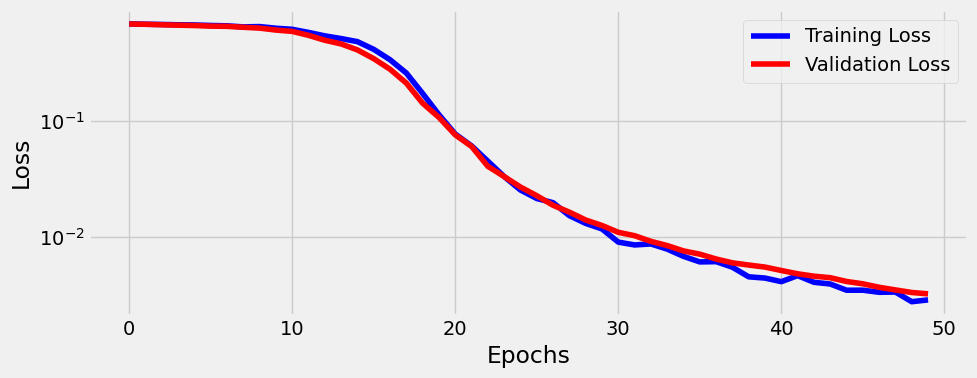

In [27]:
fig = sbs_relu.plot_losses()

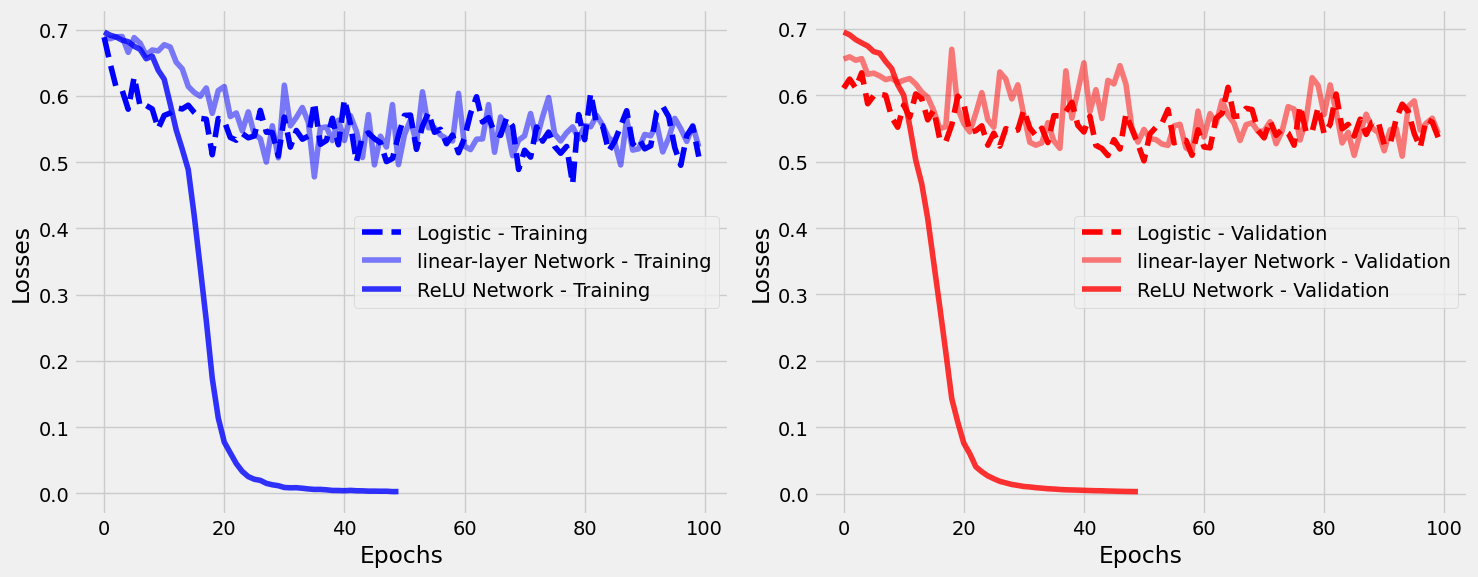

In [28]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

### Show Me the Math

$$
\large
\begin{array}{rcccccccccccc}
Hidden\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
\cdot
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
Hidden\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
\cdot
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{Activation\ \#0}
\\
Output &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
\cdot
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{Activation\ \#1}
\\
\hline
substituting\ z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{Output\ Layer}
\cdot &
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{Hidden\ Layer\#1}
\right.
&
\cdot
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{Hidden\ Layer\#0}
\right.
&
\cdot
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{Inputs}
\right)
\right)
\end{array}
$$